In [ ]:
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import datasets, layers, models

In [ ]:

TF_MODEL="cifar10"
TFL_MODEL_FILE="cifar10.tflite"

In [ ]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = datasets.cifar10.load_data()


170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

In [ ]:
# Built and train the model
def separable_conv(input, ch, idx):
    x = layers.DepthwiseConv2D((3,3), padding="same", name='dwc0_dwsc'+str(idx))(input)
    x = layers.BatchNormalization( name='bn0_dwsc'+str(idx))(x)
    x = layers.Activation("relu", name='act0_dwsc'+str(idx))(x)
    x = layers.Conv2D(ch, (1,1), padding="same", name='conv0_dwsc'+str(idx))(x)
    x = layers.BatchNormalization(name='bn1_dwsc'+str(idx))(x)
    return layers.Activation("relu", name='act1_dwsc'+str(idx))(x)

In [ ]:
input = layers.Input((32,32,3))
x = layers.Conv2D(16, (3, 3), padding='same', name='conv1')(input)
x = layers.BatchNormalization(name='bn1')(x)
x = layers.Activation("relu", name='act1')(x)
x = separable_conv(x, 24, 2)
x = layers.MaxPooling2D((2, 2), name='pool1')(x)
x = separable_conv(x, 48, 3)
x = layers.MaxPooling2D((2, 2), name='pool2')(x)
x = separable_conv(x, 96, 4)
x = separable_conv(x, 192, 5)
x = layers.MaxPooling2D((2, 2), name='pool3')(x)

In [ ]:

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10)(x)

In [ ]:

model = Model(input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 bn1 (BatchNormalization)    (None, 32, 32, 16)        64        
                                                                 
 act1 (Activation)           (None, 32, 32, 16)        0         
                                                                 
 dwc0_dwsc2 (DepthwiseConv2  (None, 32, 32, 16)        160       
 D)                                                              
                                                                 
 bn0_dwsc2 (BatchNormalizat  (None, 32, 32, 16)        64        
 ion)                                                        

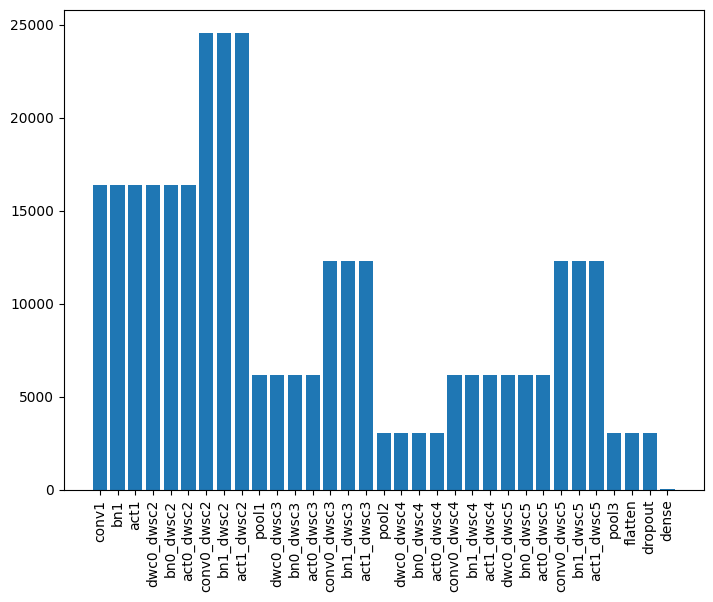

In [ ]:
fig = plt.figure(dpi=100)

ax = fig.add_axes([0,0,1,1])

l_idx   = []
l_sizes = []

for layer in model.layers[1:]:
  shape = layer.output_shape
  shape = np.delete(shape, 0)
  size  = np.prod(shape)
  l_idx   = np.append(l_idx, layer.name)
  l_sizes = np.append(l_sizes, size)

ax.bar(l_idx, l_sizes)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_imgs, train_lbls, epochs=10,
                    validation_data=(test_imgs, test_lbls))

Epoch 1/10
1563/1563 [==============================] - 159s 99ms/step - loss: 1.6060 - accuracy: 0.4590 - val_loss: 1.2376 - val_accuracy: 0.5607
Epoch 2/10
1563/1563 [==============================] - 172s 110ms/step - loss: 1.1134 - accuracy: 0.6079 - val_loss: 1.0811 - val_accuracy: 0.6167
Epoch 3/10
1563/1563 [==============================] - 156s 100ms/step - loss: 0.9449 - accuracy: 0.6675 - val_loss: 1.0579 - val_accuracy: 0.6244
Epoch 4/10
1563/1563 [==============================] - 155s 99ms/step - loss: 0.8375 - accuracy: 0.7056 - val_loss: 0.8811 - val_accuracy: 0.6964
Epoch 5/10
1563/1563 [==============================] - 157s 101ms/step - loss: 0.7581 - accuracy: 0.7348 - val_loss: 0.8262 - val_accuracy: 0.7143
Epoch 6/10
1563/1563 [==============================] - 158s 101ms/step - loss: 0.6985 - accuracy: 0.7552 - val_loss: 0.8827 - val_accuracy: 0.6998
Epoch 7/10
1563/1563 [==============================] - 151s 96ms/step - loss: 0.6570 - accuracy: 0.7694 - val_los

In [ ]:
TF_MODEL = "desktop"
model.save(TF_MODEL)


In [ ]:
model.save(TF_MODEL)

In [ ]:
cifar_ds = tf.data.Dataset.from_tensor_slices(train_imgs).batch(1)
def representative_data_gen():
  for i_value in cifar_ds.take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [ ]:
tfl_conv = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
tfl_conv.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
tfl_conv.optimizations = [tf.lite.Optimize.DEFAULT]
tfl_conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tfl_conv.inference_input_type = tf.int8
tfl_conv.inference_output_type = tf.int8

In [ ]:
#the size (in bytes) of the generated TensorFlow Lite model with no quantization
tfl_model = tfl_conv.convert()
open(TFL_MODEL_FILE, "wb").write(tfl_model)

82152

In [ ]:
print(len(tfl_model))

82152


In [ ]:
tfl_inter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
o_scale      = o_quant['scales'][0]
o_zero_point = o_quant['zero_points'][0]

def classify(i_data, o_value):
  input_data = i_value.reshape((1, 32, 32, 3))
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)

  # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return (o_pred - o_zero_point) * o_scale

num_correct_samples = 0
num_total_samples   = len(list(test_imgs))

for i_value, o_value in zip(test_imgs, test_lbls):
  o_pred_f32 = classify(i_value, o_value)
  if np.argmax(o_pred_f32) == o_value:
      num_correct_samples += 1

In [ ]:


print("Accuracy:", num_correct_samples/num_total_samples)

Accuracy: 0.728


In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i cifar10.tflite > model.h

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,065 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,735 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,455 kB]
Hit:13 https://ppa.launchpadcontent.net/ub

In [ ]:

def array_to_str(data):
    NUM_COLS = 12
    val_string = ''
    for i, val in enumerate(data):
        val_string += str(val)

        if (i + 1) < len(data):
            val_string += ','
        if (i + 1) % NUM_COLS == 0:
            val_string += '\n'
    return val_string

In [ ]:

def gen_h_file(size, data, ilabel):
  str_out = f'int8_t g_test[] = '
  str_out += "\n{\n"
  str_out += f'{data}'
  str_out += '};\n'
  str_out += f"const int g_test_len = {size};\n"
  str_out += f"const int g_test_ilabel = {ilabel};\n"
  return str_out

In [ ]:

imgs = list(zip(test_imgs, test_lbls))
cols = ['Image', 'Label']
df = pd.DataFrame(imgs, columns = cols)


In [ ]:

cond = df['Label'] == 8
ship_samples = df[cond]

In [ ]:

c_code = ""

for index, row in ship_samples.iterrows():
  i_value = np.asarray(row['Image'].tolist())
  o_value = np.asarray(row['Label'].tolist())
  o_pred_f32 = classify(i_value, o_value)
  if np.argmax(o_pred_f32) == o_value:
    i_value_f32 = i_value / i_scale + i_zero_point
    i_value_s8  = i_value_f32.astype(dtype=np.uint8)
    i_value_s8  = i_value_s8.ravel()

    # Generate a string from NumPy array
    val_string = array_to_str(i_value_s8)

    c_code = gen_h_file(i_value_s8.size, val_string, "8")
    break

In [ ]:
with open("input.h", 'w') as file:
  file.write(c_code)

In [ ]:
test_image = np.expand_dims(test_imgs[0], axis=0).astype(np.float32)

plt.figure(figsize=(3,3))
plt.imshow(test_imgs[0])

In [ ]:
test_imgs.shape

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
interpreter = tf.lite.Interpreter(model_path='cifar10.tflite')

In [ ]:
#interpreter.set_tensor(i_details[0]['index'], test_image)
#interpreter.invoke()
#predictions = interpreter.get_tensor(o_details[0]['index'])
tfl_inter.set_tensor(i_details["index"], i_value_s8)
tfl_inter.invoke()
o_pred = tfl_inter.get_tensor(o_details["index"])[0]



prediction_class = np.argmax(o_pred)
prediction_class_name = class_names[prediction_class]
prediction_class_name